# AI Prediction Using Machine Learning

### APGCE* 2019 Geohackaton First Runner Up
*Asian Petroleum Geoscience Conference and Exhibition

#### Team 7: sAIsWell
---
Team Members:
1. Menezes, Russell
2. M. Tarik, Haizad M.
3. Low, Tsu Siang
4. Ham, Wen Yi
5. Lee, Brandon A.

## Introduction
The Geohackaton was conducted by PETRONAS on 25<sup>th</sup> - 27<sup>th</sup> October 2019 and this project was presented in the APGCE itself on the 29<sup>th</sup> October 2019 as one of the winning teams.

The goal of this project is to create an alternative to inversion method widely used in the petroleum industy to generate acoustic impedance (AI) from seismic data.

Dataset used have been changed due to confidentiallity of the original data used in the hackathon, as well as cleaning up many codes.

## References and links
1. https://segyio.readthedocs.io/
2. https://lasio.readthedocs.io/
3. https://wiki.seg.org/wiki/SEAM_Phase_I:_Interpretation_challenge_I_-_Depth

## Methods

1. Data Pre-processing
    1. Extraction of well data from well-logs.
    2. Extraction of seismic headers and trace
    3. Finding nearest seismic trace
    4. Resampling of well data to match seismic sampling
    
    
2. Feature Engineering
    5. Extracting seismic trace nearest to well
    6. Seismic attributes generation
    
    
3. Hyperparameterizations and Model validation
    7. Semi-automated hyper-parameterizations
    
    
4. Prediction
    8. AI prediction on selected seismic inline

# 1. Data Pre-processing

## A. Extract data from well-logs

In [2]:
%matplotlib inline
import os
import lasio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bruges as br
import scipy as sp
import re
import segyio
import csv
import glob
import seaborn as sns; sns.set_context('talk');sns.set_style('darkgrid')

#### Extraction test on single Las file

In [3]:
data_dir = 'data/SEAM_wells/'
filename = 'well5.las'

In [4]:
ai_df = pd.DataFrame()
# temp_df = pd.DataFrame()
las_file = lasio.read(os.path.join(data_dir, filename))

print(las_file.header['Curves'].keys())
print(las_file.curves.Density.unit)
print(las_file.curves.Vp.unit)

logs = las_file.header['Curves'].keys()
if ('DENSITY'in logs) and ('VP' in logs):
    print('test')
    well_df = las_file.df() 
    well_df.replace(-999.25,np.nan)
    well_df.dropna(inplace=True)
    ai_df['AI'] = well_df['DENSITY'].multiply(well_df['VP'])

Header section Parameter regexp=~P was not found.


['DEPTH', 'BEDDIPX', 'BEDDIPY', 'DELTA', 'DENSITY', 'EPSILON', 'GAMMA', 'GEOINDEXRES', 'GEOSALTINDEX', 'LAYERGEOINDEX', 'POROSITYEFFECTIVE', 'POROSITYTOTAL', 'RESISTIVITYHORIZONTAL', 'RESISTIVITYNORMAL', 'RESISTIVITYPARALLEL', 'RESISTIVITYVERTICAL', 'TTIDIPX', 'TTIDIPY', 'VP', 'VSELASTICORIGINAL', 'VSELASTICSIM', 'VSHALE']
g/cm3
m/s
test


In [5]:
ai_df.head().T

DEPTH    0.0     10.0    20.0    30.0    40.0
AI     1534.7  1534.7  1534.7  1534.7  1534.7

#### Well heads extraction and logs merging

In [6]:
wellheads_df = pd.DataFrame(columns=['filename', 'well_name', 'x', 'y', 'lat', 'lon'])
merged_data_df = pd.DataFrame(columns=['filename', 'well_name', 'x', 'y', 'lat', 'lon'])
# interprete_df = pd.DataFrame(columns=['filename', 'well_name', 'x', 'y', 'lat', 'lon'])
i = 0
for filename in os.listdir(data_dir):
    if not filename.startswith('.'):
        las_file = lasio.read(os.path.join(data_dir, filename))
        well_name = las_file.well.WELL.value
        if 'X' in las_file.well.keys():
            if las_file.well.X.value == '':
                x = np.nan
            else:
                x = las_file.well.X.value
        else:
            x = np.nan
        if 'Y' in las_file.well.keys():
            if las_file.well.Y.value == '':
                y = np.nan
            else:
                y = las_file.well.Y.value
        else:
            y = np.nan
        if 'LATI' in las_file.well.keys(): 
            if las_file.well.LATI.value == '':
                lat = np.nan
            else:
                lat = las_file.well.LATI.value
        else:
            lat = np.nan
        if 'LONG' in las_file.well.keys():
            if las_file.well.LONG.value == '':
                lon = np.nan
            else:
                lon = las_file.well.LONG.value
        else:
            lon = np.nan
        logs = las_file.header['Curves'].keys()
        temp_df = pd.DataFrame({'filename':[filename], 'well_name':[well_name], 'x':[x], 'y':[y], 'lat':[lat], 'lon':[lon], 'logs':[logs]})
#         if 'COMPOS' in filename:
#             composite_df = pd.concat([composite_df,temp_df], axis=0, ignore_index=True, sort=False)
#         elif 'INTERPRET' in filename:
#             interprete_df = pd.concat([interprete_df,temp_df], axis=0, ignore_index=True, sort=False) 
        wellheads_df = pd.concat([wellheads_df,temp_df], axis=0, ignore_index=True, sort=False)
        
        temp_df = las_file.df() 
        temp_df.replace(-999.25,np.nan)
        #     df.dropna
        temp_df.insert(0,'DEPTH', temp_df.index)
        temp_df.insert(0,'lon', lon)
        temp_df.insert(0,'lat', lat)
        temp_df.insert(0,'y', y)
        temp_df.insert(0,'x', x)
        temp_df.insert(0,'well_name', well_name)
        temp_df.insert(0,'filename', filename)
        merged_data_df = pd.concat([merged_data_df,temp_df], axis=0, ignore_index=True, sort=False)

Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.


In [7]:
wellheads_df

filename well_name      x      y  lat  lon  \
0  well3.las     well3  15025  23900  NaN  NaN   
1  well5.las     well5  15025  22900  NaN  NaN   

                                                logs  
0  [DEPTH, BEDDIPX, BEDDIPY, DELTA, DENSITY, EPSI...  
1  [DEPTH, BEDDIPX, BEDDIPY, DELTA, DENSITY, EPSI...

In [8]:
merged_data_df

filename well_name      x      y  lat  lon    DEPTH  BEDDIPX  BEDDIPY  \
0     well3.las     well3  15025  23900  NaN  NaN      0.0      0.0      0.0   
1     well3.las     well3  15025  23900  NaN  NaN     10.0      0.0      0.0   
2     well3.las     well3  15025  23900  NaN  NaN     20.0      0.0      0.0   
3     well3.las     well3  15025  23900  NaN  NaN     30.0      0.0      0.0   
4     well3.las     well3  15025  23900  NaN  NaN     40.0      0.0      0.0   
...         ...       ...    ...    ...  ...  ...      ...      ...      ...   
2997  well5.las     well5  15025  22900  NaN  NaN  14960.0      0.0      0.0   
2998  well5.las     well5  15025  22900  NaN  NaN  14970.0      0.0      0.0   
2999  well5.las     well5  15025  22900  NaN  NaN  14980.0      0.0      0.0   
3000  well5.las     well5  15025  22900  NaN  NaN  14990.0      0.0      0.0   
3001  well5.las     well5  15025  22900  NaN  NaN  15000.0      0.0      0.0   

      DELTA  ...  RESISTIVITYHORIZONTAL  RESISTIVITYNORMAL  \
0       0.0  ...                    0.3                0.3   
1       0.0  ...                    0.3                0.3   
2       0.0  ...                    0.3                0.3   
3       0.0  ...                    0.3                0.3   
4       0.0  ...                    0.3                0.3   
...     ...  ...                    ...                ...   
2997    0.0  ...                   20.0               20.0   
2998    0.0  ...                   20.0               20.0   
2999    0.0  ...                   20.0               20.0   
3000    0.0  ...                   20.0               20.0   
3001    0.0  ...                   20.0               20.0   

      RESISTIVITYPARALLEL  RESISTIVITYVERTICAL  TTIDIPX  TTIDIPY      VP  \
0                     0.3                  0.3      0.0      0.0  1490.0   
1                     0.3                  0.3      0.0      0.0  1490.0   
2                     0.3                  0.3      0.0      0.0  1490.0   
3                     0.3                  0.3      0.0      0.0  1490.0   
4                     0.3                  0.3      0.0      0.0  1490.0   
...                   ...                  ...      ...      ...     ...   
2997                 20.0                 20.0      0.0      0.0  4200.0   
2998                 20.0                 20.0      0.0      0.0  4200.0   
2999                 20.0                 20.0      0.0      0.0  4200.0   
3000                 20.0                 20.0      0.0      0.0  4200.0   
3001                 20.0                 20.0      0.0      0.0  4200.0   

      VSELASTICORIGINAL  VSELASTICSIM  VSHALE  
0                   0.0           0.0     0.0  
1                   0.0           0.0     0.0  
2                   0.0           0.0     0.0  
3                   0.0           0.0     0.0  
4                   0.0           0.0     0.0  
...                 ...           ...     ...  
2997             2960.0        2960.0     0.0  
2998             2960.0        2960.0     0.0  
2999             2960.0        2960.0     0.0  
3000             2960.0        2960.0     0.0  
3001             2960.0        2960.0     0.0  

[3002 rows x 28 columns]

#### Drop rows without any logs data

In [9]:
merged_data_df.drop(['lon','lat'], axis=1);

In [10]:
cleaned_df = pd.DataFrame(columns=['well_name'])
for filename in os.listdir(data_dir):
    if 'COMPOS' in filename:
        continue
    else:
        if not filename.startswith('.'):
            las_file = lasio.read(os.path.join(data_dir,filename))
            well_name = las_file.well.WELL.value   
    #         if ('WELL-02' in well_name) or ('WELL-03' in well_name) or ('WELL-1' in well_name) or ('WELL-4' in well_name) or ('WELL6G-1.1' in well_name) or ('WELL6G-1_1B' in well_name) or ('WELL6G-1_2' in well_name) or ('WELL-A4' in well_name) or ('WELL-A5' in well_name) or ('WELL-B24S1' in well_name):
            temp_df = las_file.df()
            temp_df.replace(-999.25,np.nan)
            temp_df.insert(0,'DEPTH', temp_df.index)
            temp_df.insert(0,'well_name', well_name)
#             data_df = pd.concat([data_df,temp_df], axis=0, ignore_index=True, sort=False)
            cleaned_df = pd.concat([cleaned_df,temp_df.dropna() ], axis=0, ignore_index=True, sort=False)
    #         else:
    #             continue
# print(data_df.shape)
print(cleaned_df.shape)

Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.


(3002, 23)


In [11]:
cleaned_df

well_name    DEPTH  BEDDIPX  BEDDIPY  DELTA  DENSITY  EPSILON  GAMMA  \
0        well3      0.0      0.0      0.0    0.0     1.03      0.0    0.0   
1        well3     10.0      0.0      0.0    0.0     1.03      0.0    0.0   
2        well3     20.0      0.0      0.0    0.0     1.03      0.0    0.0   
3        well3     30.0      0.0      0.0    0.0     1.03      0.0    0.0   
4        well3     40.0      0.0      0.0    0.0     1.03      0.0    0.0   
...        ...      ...      ...      ...    ...      ...      ...    ...   
2997     well5  14960.0      0.0      0.0    0.0     2.70      0.0    0.0   
2998     well5  14970.0      0.0      0.0    0.0     2.70      0.0    0.0   
2999     well5  14980.0      0.0      0.0    0.0     2.70      0.0    0.0   
3000     well5  14990.0      0.0      0.0    0.0     2.70      0.0    0.0   
3001     well5  15000.0      0.0      0.0    0.0     2.70      0.0    0.0   

      GEOINDEXRES  GEOSALTINDEX  ...  RESISTIVITYHORIZONTAL  \
0            10.0          10.0  ...                    0.3   
1            10.0          10.0  ...                    0.3   
2            10.0          10.0  ...                    0.3   
3            10.0          10.0  ...                    0.3   
4            10.0          10.0  ...                    0.3   
...           ...           ...  ...                    ...   
2997          1.0           1.0  ...                   20.0   
2998          1.0           1.0  ...                   20.0   
2999          1.0           1.0  ...                   20.0   
3000          1.0           1.0  ...                   20.0   
3001          1.0           1.0  ...                   20.0   

      RESISTIVITYNORMAL  RESISTIVITYPARALLEL  RESISTIVITYVERTICAL  TTIDIPX  \
0                   0.3                  0.3                  0.3      0.0   
1                   0.3                  0.3                  0.3      0.0   
2                   0.3                  0.3                  0.3      0.0   
3                   0.3                  0.3                  0.3      0.0   
4                   0.3                  0.3                  0.3      0.0   
...                 ...                  ...                  ...      ...   
2997               20.0                 20.0                 20.0      0.0   
2998               20.0                 20.0                 20.0      0.0   
2999               20.0                 20.0                 20.0      0.0   
3000               20.0                 20.0                 20.0      0.0   
3001               20.0                 20.0                 20.0      0.0   

      TTIDIPY      VP  VSELASTICORIGINAL  VSELASTICSIM  VSHALE  
0         0.0  1490.0                0.0           0.0     0.0  
1         0.0  1490.0                0.0           0.0     0.0  
2         0.0  1490.0                0.0           0.0     0.0  
3         0.0  1490.0                0.0           0.0     0.0  
4         0.0  1490.0                0.0           0.0     0.0  
...       ...     ...                ...           ...     ...  
2997      0.0  4200.0             2960.0        2960.0     0.0  
2998      0.0  4200.0             2960.0        2960.0     0.0  
2999      0.0  4200.0             2960.0        2960.0     0.0  
3000      0.0  4200.0             2960.0        2960.0     0.0  
3001      0.0  4200.0             2960.0        2960.0     0.0  

[3002 rows x 23 columns]

#### Leave only density and sonic

In [12]:
col_list = ['well_name','DEPTH','VP', 'DENSITY']
filtered_df = cleaned_df[col_list]
filtered_df

well_name    DEPTH      VP  DENSITY
0        well3      0.0  1490.0     1.03
1        well3     10.0  1490.0     1.03
2        well3     20.0  1490.0     1.03
3        well3     30.0  1490.0     1.03
4        well3     40.0  1490.0     1.03
...        ...      ...     ...      ...
2997     well5  14960.0  4200.0     2.70
2998     well5  14970.0  4200.0     2.70
2999     well5  14980.0  4200.0     2.70
3000     well5  14990.0  4200.0     2.70
3001     well5  15000.0  4200.0     2.70

[3002 rows x 4 columns]

In [13]:
filtered_df['AI'] = filtered_df['DENSITY'] * filtered_df['VP']
filtered_df.head()

/Users/brandonallenlee/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


well_name  DEPTH      VP  DENSITY      AI
0     well3    0.0  1490.0     1.03  1534.7
1     well3   10.0  1490.0     1.03  1534.7
2     well3   20.0  1490.0     1.03  1534.7
3     well3   30.0  1490.0     1.03  1534.7
4     well3   40.0  1490.0     1.03  1534.7

#### Data QC

In [14]:
from scipy.fftpack import fft, ifft
import math

def plot_qc(well_log):
    w_name = well_log['well_name'].unique()
    N = len(well_log['AI'])

    depth_fft = fft(well_log['DEPTH'].values)
    fourier = np.fft.fft(well_log['AI'])
    freq = np.fft.fftfreq(N, 1/10)
    
    plt.figure(1, figsize=(10,5)).tight_layout()
    plt.subplot(211)
    plt.plot(well_log['DEPTH'].values)
    plt.title(str('Depth of ' + w_name))
    plt.subplot(212)
    plt.plot(freq, np.sqrt((fourier.real**2) + (fourier.imag**2)))
    plt.xlim(0, 1)
    plt.title('AI spectrum of' + w_name)
#     plt.show()

    ai_fft = fft(well_log['AI'].values)
    ai_ifft = ifft(ai_fft)
    plt.figure(2, figsize=(10,5)).tight_layout()
    plt.subplot(111)
    plt.plot(well_log['DEPTH'].values, well_log['AI'].values, linewidth=2.0)
    plt.plot(well_log['DEPTH'].values, ai_ifft, linewidth=1, linestyle='--')
    # plt.gca().invert_yaxis()
    plt.title('AI fft and inverse fft')
    plt.show()
# plt.xlim((0,4))
# plt.ylim((0,0.5))


/Users/brandonallenlee/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


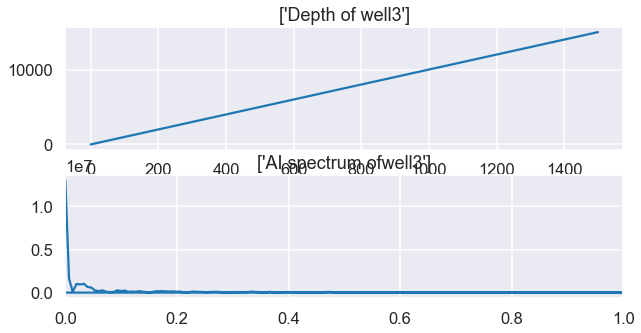

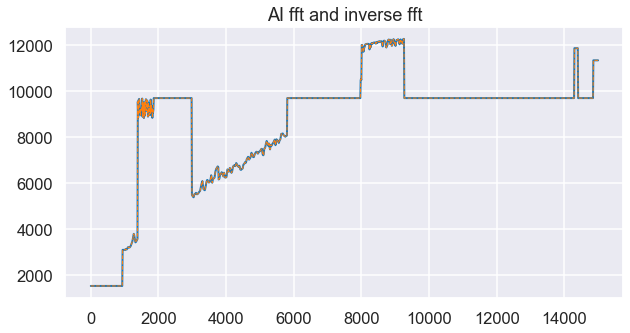

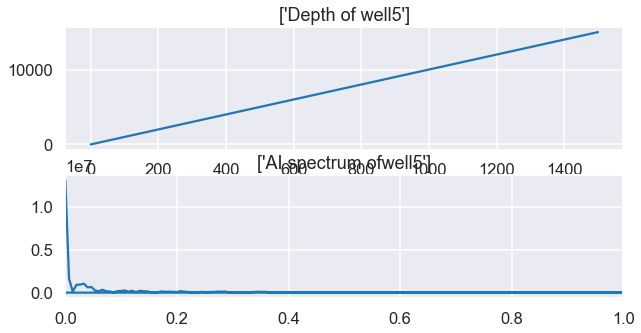

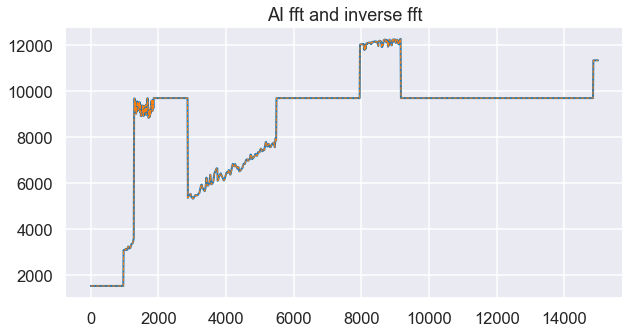

In [15]:
for i, j in filtered_df.groupby('well_name'):
    plot_qc(j)

## B. Seismic Data Extraction

#### Get seismic header

In [16]:
segy = 'data/seismic/SEAM_Interpretation_Challenge_1_Depth.sgy'

In [17]:
def get_seismic_header(segy):
    from segyio import TraceField
    # generate seismic header file containing cdp, x, y, inline, xline from input seismic
    hword = {'cdp': TraceField.CDP, 'x': TraceField.CDP_X,
             'y': TraceField.CDP_Y, 'iline': TraceField.INLINE_3D,
             'xline': TraceField.CROSSLINE_3D,
             'trace':TraceField.TRACE_SEQUENCE_LINE}
    with segyio.open(segy, ignore_geometry=True) as f:
        tlist = []
        generator = (n for n in f.header)
        for i in generator:
#             extract the header wanted
            data = [i.get(x) for x in hword.values()]
            tlist.append(data)
        # create dataframe representation of the seismic header
        seismic_header = pd.DataFrame(tlist)
        seismic_header.columns = hword.keys()
        
        # if trace numbering not equal to trace calculation
        trace_n = len(f.trace)
        if len(f.trace) != seismic_header['trace'].max():
            seismic_header['trace'] = np.arange(1, trace_n+1, 1)
        return seismic_header

In [18]:
%time seismic_header = get_seismic_header(segy)

CPU times: user 17.3 s, sys: 2.36 s, total: 19.7 s
Wall time: 50.9 s


In [19]:
seismic_header.head()

cdp     x     y  iline  xline  trace
0  1499  2490  2490   1499   1499      1
1  1499  2520  2490   1505   1499      2
2  1499  2550  2490   1511   1499      3
3  1499  2580  2490   1517   1499      4
4  1499  2610  2490   1523   1499      5

## C. Find closest trace, inline, and crossline to wells

In [20]:
def get_well_trace_location(seismic_df, wells_df):
    from scipy import spatial
    # get the inline/xline/x/y of the closest seismic traces to a list of wells
    temp_df = wells_df.copy(deep=True)
    # create KDTree
    seismicxy = seismic_df[['x', 'y']]
    tree = spatial.KDTree(seismicxy)

    # query nearest neighbour
    pts = temp_df[['x', 'y']]
    result = tree.query(pts)
    temp_df['trace_distance'] = result[0]
    temp_df['trace_x'] = seismicxy.iloc[result[1]]['x'].values
    temp_df['trace_y'] = seismicxy.iloc[result[1]]['y'].values
    temp_df['iline'] = seismic_df.iloc[result[1]]['iline'].values
    temp_df['xline'] = seismic_df.iloc[result[1]]['xline'].values
    temp_df['trace'] = seismic_df.iloc[result[1]]['trace'].values
    return temp_df

In [21]:
%time well_seismic_loc = get_well_trace_location(seismic_header, wellheads_df)

CPU times: user 6.57 s, sys: 150 ms, total: 6.72 s
Wall time: 6.75 s


In [22]:
well_seismic_loc.T

0  \
filename                                                well3.las   
well_name                                                   well3   
x                                                           15025   
y                                                           23900   
lat                                                           NaN   
lon                                                           NaN   
logs            [DEPTH, BEDDIPX, BEDDIPY, DELTA, DENSITY, EPSI...   
trace_distance                                            11.1803   
trace_x                                                     15030   
trace_y                                                     23910   
iline                                                        4007   
xline                                                        5783   
trace                                                      715847   

                                                                1  
filename                                                well5.las  
well_name                                                   well5  
x                                                           15025  
y                                                           22900  
lat                                                           NaN  
lon                                                           NaN  
logs            [DEPTH, BEDDIPX, BEDDIPY, DELTA, DENSITY, EPSI...  
trace_distance                                            11.1803  
trace_x                                                     15030  
trace_y                                                     22890  
iline                                                        4007  
xline                                                        5579  
trace                                                      681779

#### Well and seismic location QC

In [23]:
def plot_map(seismic_df, wells_df, inlineskip=1):
    skip = inlineskip
    fig, ax = plt.subplots(figsize=(10,10))
    grouped = seismic_df.groupby('iline')
    j = seismic_df['iline'].min()
    n_inline = len(grouped)
    n = 0
    for name, group in grouped:
        n = n + 1
        if n % skip == 0:
            plt.plot(group['x'], group['y'], linewidth=1, c='b')
    plt.scatter(wells_df['trace_x'], wells_df['trace_y'], alpha=0.3, c='r')
    for i, txt in enumerate(wells_df['well_name']):
        ax.annotate(txt, (wells_df['trace_x'][i], wells_df['trace_y'][i]))
    plt.title('Map of seismic and wells')

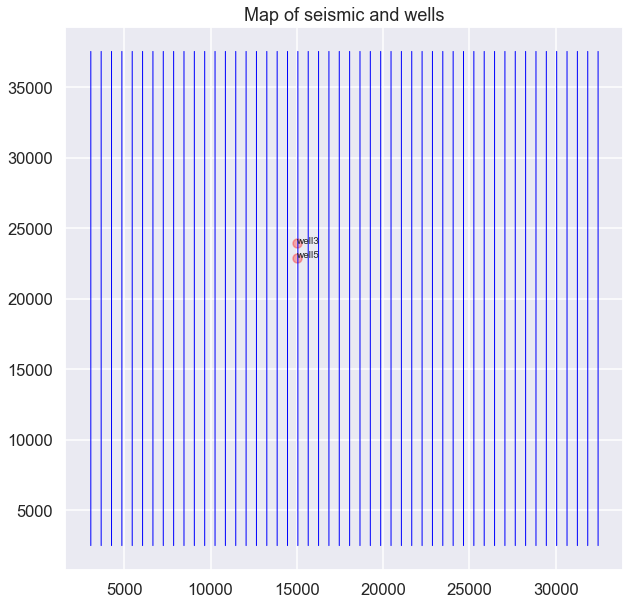

In [24]:
plot_map(seismic_header, well_seismic_loc, inlineskip=20)

#### Preview Seismic Section

In [25]:
def plot_seismic(segy, header_df, inline_no=0):
    with segyio.open(segy, ignore_geometry=True) as f:
        i_min = header_df['iline'].min()
        i_max = header_df['iline'].max()
        inline_no = i_min if inline_no < i_min else i_max if inline_no > i_max else inline_no

        line = header_df[header_df['iline'] == inline_no].copy()
        raw_trace = []
        trace_numbers_list = []
        for i,j in line.iterrows():
            trc_no = j['trace']
            trace = f.trace[trc_no]
            trace_numbers_list.append(trc_no)
            raw_trace.append(trace)

        output_raw_trace = pd.DataFrame(raw_trace, trace_numbers_list).T
        fig = plt.figure(figsize=(18, 10))
        extent = [output_raw_trace.columns.min(), output_raw_trace.columns.max(),
                  output_raw_trace.index.max()*20, output_raw_trace.index.min()*20]
        ax = fig.add_subplot(1, 1, 1)
        vm = np.percentile(output_raw_trace, 99)
        ax.imshow(output_raw_trace, cmap="RdBu", vmin=-vm, vmax=vm, aspect='auto', extent=extent)
        plt.title('inline '+str(inline_no))

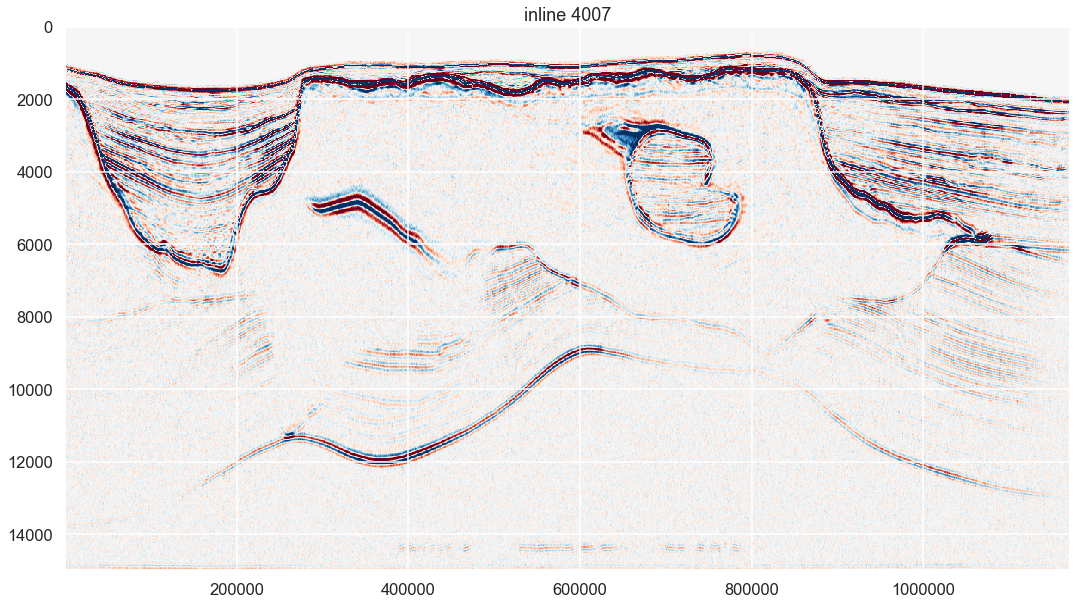

In [26]:
inline_number = well_seismic_loc.iloc[0]['iline']
plot_seismic(segy, seismic_header, inline_no=inline_number)

In [27]:
def get_well_geometry(well_name, well_loc, well_df):
    well_idx = well_loc.index[well_loc['well_name'] == well_name].values
    well_loc = well_loc.iloc[well_idx]['trace']
    
    well_depth = well_df['DEPTH']
    xs = [well_loc, well_loc]
    ys = [well_depth.values.min(), well_depth.max()]
#     well_ext = [, well_loc], [well_loc, ] 
    return xs, ys

Text(0    715847
Name: trace, dtype: int64, 0.0, 'well3')

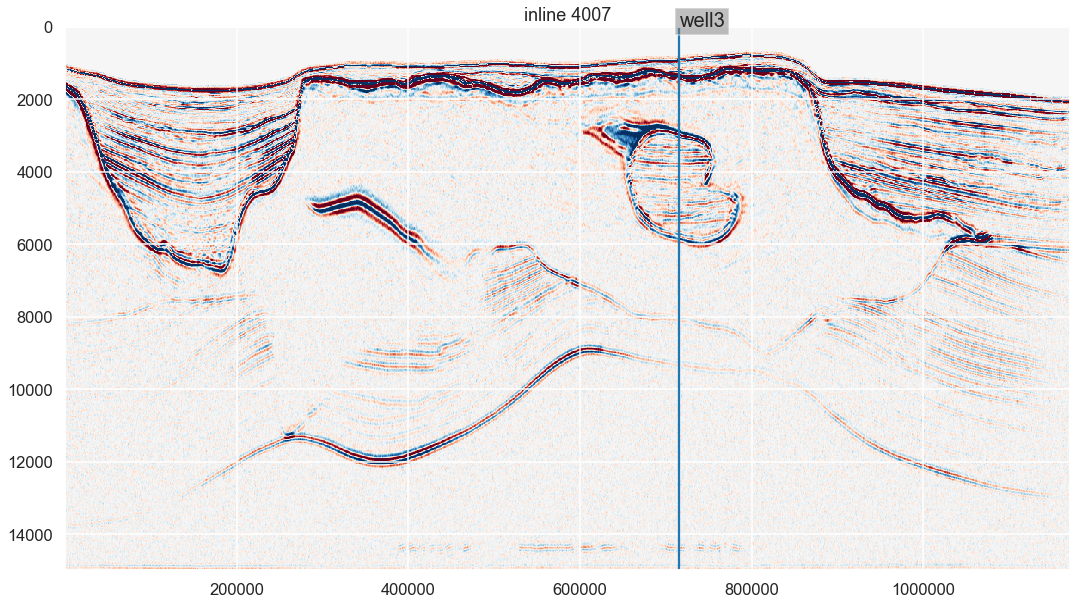

In [28]:
well_xs, well_ys = get_well_geometry('well3',
                                     well_seismic_loc,
                                     filtered_df)
plot_seismic(segy, seismic_header, inline_no=inline_number)
plt.plot(well_xs, well_ys)
plt.text(well_xs[0], well_ys[0], s='well3',
        fontsize=20, bbox=dict(facecolor='grey', alpha=0.5))



## D. Well Logs Resampling

In [29]:
def resample_logs(well_log, median_filter_sample=0, seismic_sample=100):
    w_name = well_log['well_name'].unique()
    # Define parameters for the Median filter
    lb = seismic_sample # Seimic Sampling Interval
    dz = 10  # Log sampling interval in meters

    new_df = pd.DataFrame()
    depth = well_log['DEPTH'].values
    ai = well_log['AI'].values
    rhob = well_log['DENSITY'].values
    ai_bks = br.filters.median(ai, median_filter_sample)

    f = sp.interpolate.interp1d(depth, ai_bks)
    depth_new = np.arange(round(min(depth)),max(depth), lb)
    ai_resampled = f(depth_new)
    new_df['well_name'] = np.ravel([w_name] * len(depth_new))
    new_df['DEPTH'] = depth_new
    new_df['AI'] = ai_resampled
    plt.figure(1, figsize=(20,10)).tight_layout()
    plt.subplot(141)
    plt.plot(ai,depth,'b',label='AI')
    plt.plot(ai_resampled, depth_new, 'r', label='AI Resampled', linestyle='--')
    plt.gca().invert_yaxis()
    plt.title(f'AI logs of {w_name}')
    plt.legend()


    new_depth_fft = fft(new_df['DEPTH'].values)
    new_fourier = np.fft.fft(new_df['AI'])
    new_freq = np.fft.fftfreq(len(new_df['AI']), 10)

    plt.subplot(122)
    plt.magnitude_spectrum(ai, Fs=1/dz, color='b', scale='dB', label='AI')
    plt.magnitude_spectrum(ai_resampled, Fs=1/lb, color='r', scale='dB',
                           label='AI Resampled', linestyle='--')
    plt.title(f'Frequency Spectrum of {w_name}')
    plt.legend()
    plt.show()
    return new_df

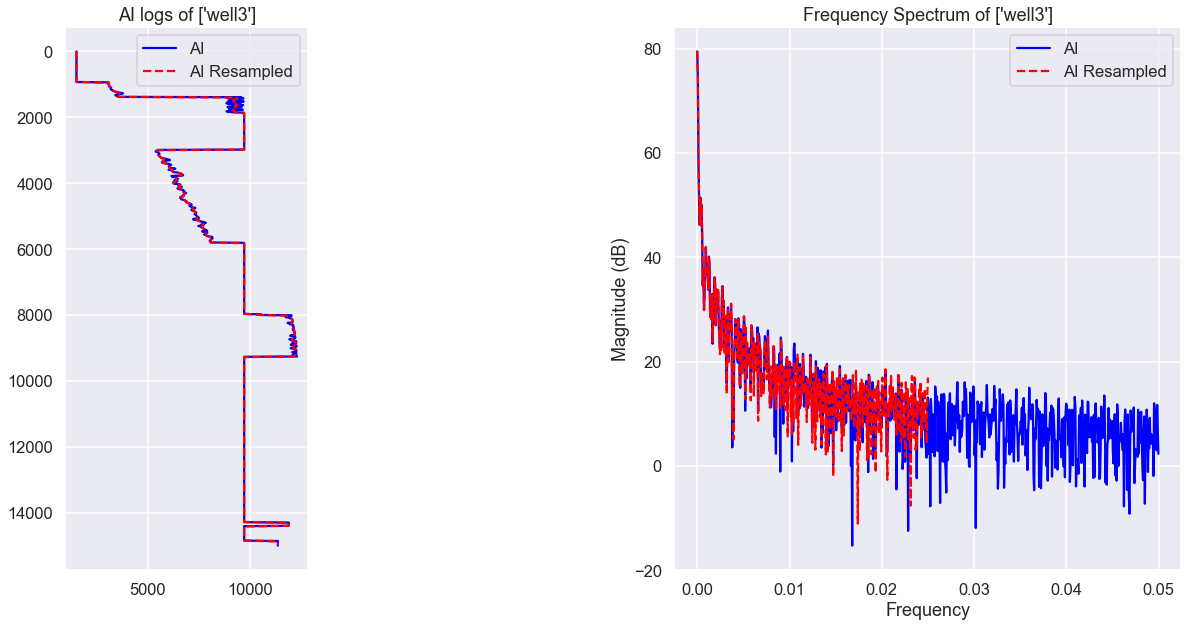

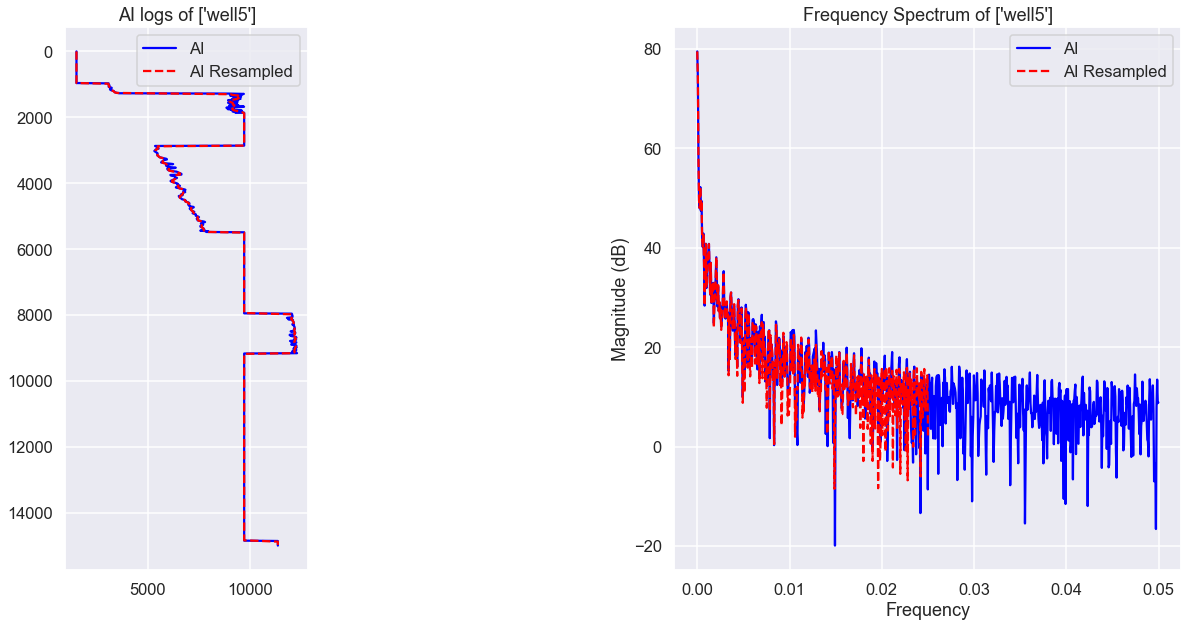

In [30]:
resampled_logs = pd.DataFrame(columns=['well_name','DEPTH', 'AI'])
for i,j in filtered_df.groupby('well_name'):
    new_logs = resample_logs(j, median_filter_sample=10, seismic_sample=20)
    resampled_logs = pd.concat([resampled_logs, new_logs], axis=0, ignore_index=True, sort=True)    

In [31]:
resampled_logs

AI    DEPTH well_name
0      1534.7      0.0     well3
1      1534.7     20.0     well3
2      1534.7     40.0     well3
3      1534.7     60.0     well3
4      1534.7     80.0     well3
...       ...      ...       ...
1495  11340.0  14900.0     well5
1496  11340.0  14920.0     well5
1497  11340.0  14940.0     well5
1498  11340.0  14960.0     well5
1499  11340.0  14980.0     well5

[1500 rows x 3 columns]

# 2. Feature Engineering

## E. Extract trace as well log

In [32]:
def extract_trace(well_head, segy):
    # return array of trace values and its depth/time index
    well = well_head
    with segyio.open(segy, ignore_geometry=True) as f:
        trace = f.trace.raw[well['trace']]
        index = f.samples
    return index, trace

In [33]:
temp_list = []
for index, row in well_seismic_loc.iterrows():
    temp_list.append([row['well_name'], *extract_trace(row, segy)])
well_seismic = pd.DataFrame(temp_list)
well_seismic.columns = ['well_name', 'z','trace']
well_seismic

well_name                                                  z  \
0     well3  [0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...   
1     well5  [0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...   

                                               trace  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

#### QC seismic trace along well

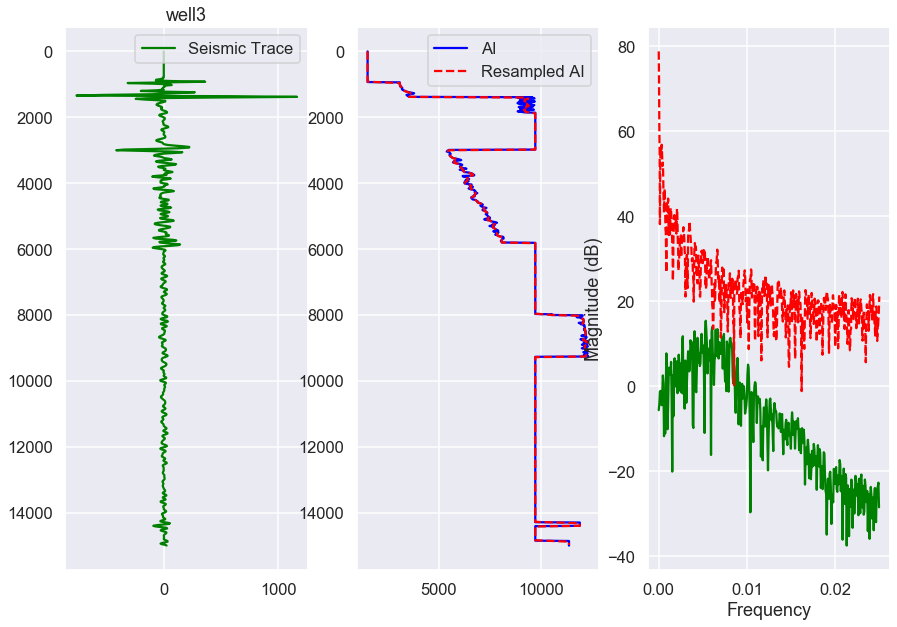

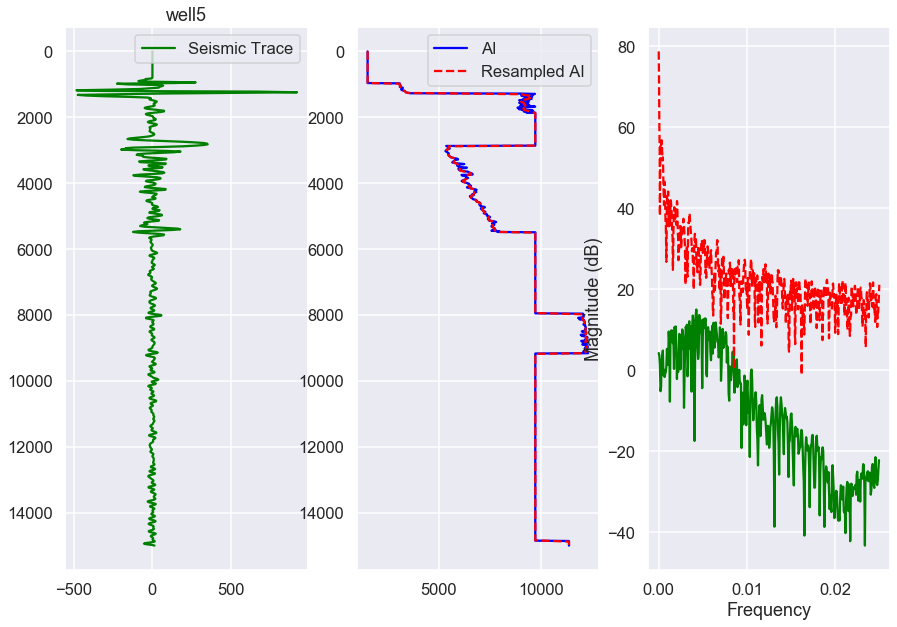

In [34]:
for i, row in well_seismic.iterrows():
    n_well = row['well_name']
    plt.figure(1, figsize=(20,10)).tight_layout()
    plt.subplot(141)
    plt.plot(row['trace'], row['z'], color='g', label='Seismic Trace')
    plt.legend()
    
    plt.gca().invert_yaxis()
    plt.title(row['well_name'])
    plt.subplot(142)
    
    res_log = resampled_logs[resampled_logs['well_name'] == n_well]
    ori_log = filtered_df[filtered_df['well_name'] == n_well]
    
    plt.plot(ori_log['AI'], ori_log['DEPTH'], color='b', label='AI')
    plt.plot(res_log['AI'], res_log['DEPTH'], color='r',
             linestyle='--', label='Resampled AI')
    plt.legend()
    plt.gca().invert_yaxis()


    
    fourier = np.fft.fft(row['trace'])
    freq = np.fft.fftfreq(len(row['trace']), 20)

    plt.subplot(122, adjustable='box', aspect=1)
    temp_df = pd.DataFrame(row['trace'], row['z'])
    temp_df.columns = ['trace']

    sliced = temp_df['trace'].values
    plt.subplot(143)
    plt.magnitude_spectrum(sliced, Fs=1/20, color='g', scale='dB',
                           label='Seismic')
    plt.magnitude_spectrum(resampled_logs['AI'], Fs=1/20, color='r', scale='dB',
                          linestyle='--', label='Resampled AI')
    plt.show()

    

## F. Seismic Attributes Generation

#### Instantaneous phase

In [35]:
from scipy import fftpack
def ins_phase(col):
    ansignal = fftpack.hilbert(col)
    ins_phase = np.unwrap(np.angle(ansignal))
    return ins_phase

#### Instantaneous Frequency

In [36]:
from scipy import fftpack
def ins_freq(col,rate=20):
    ins_pha = ins_phase(col)

    ins_freq = (np.diff(ins_pha) / (2.0*np.pi) * (1/rate))
    return ins_freq

#### Envelope

In [37]:
from scipy import fftpack
def envelope(col):
    an_sig = fftpack.hilbert(col)
    amp_env = np.abs(an_sig)
    return amp_env

Merge Seismic trace as well log

In [38]:
resampled_logs[resampled_logs['well_name'] == 'well3']

AI    DEPTH well_name
0     1534.7      0.0     well3
1     1534.7     20.0     well3
2     1534.7     40.0     well3
3     1534.7     60.0     well3
4     1534.7     80.0     well3
..       ...      ...       ...
745  11340.0  14900.0     well3
746  11340.0  14920.0     well3
747  11340.0  14940.0     well3
748  11340.0  14960.0     well3
749  11340.0  14980.0     well3

[750 rows x 3 columns]

In [39]:
well_traces = pd.DataFrame(columns=['DEPTH', 'trace', 'well_name'])
for i, row in well_seismic.iterrows():
    tempdf = pd.DataFrame()
    tempdf['DEPTH'] = row['z']
    tempdf['trace'] = row['trace']
    tempdf['well_name'] = row['well_name']
    well_traces = pd.concat([well_traces, tempdf], axis=0, ignore_index=True)

well_traces

DEPTH      trace well_name
0         0.0   0.000000     well3
1        20.0   0.000000     well3
2        40.0   0.000000     well3
3        60.0   0.000000     well3
4        80.0   0.000000     well3
...       ...        ...       ...
1497  14920.0 -38.015244     well5
1498  14940.0 -54.088974     well5
1499  14960.0 -38.198975     well5
1500  14980.0  -1.888535     well5
1501  15000.0  13.152909     well5

[1502 rows x 3 columns]

In [40]:
# merged_log = pd.concat([well_traces, resampled_logs], axis=1, ignore_index=True)
merged_log = pd.DataFrame(columns=['DEPTH', 'trace', 'well_name'])
for i, j in well_traces.groupby('well_name'):
    j.drop('well_name', axis=1, inplace=True)
    temp = j.join(resampled_logs[resampled_logs['well_name']==i].set_index('DEPTH'), on ='DEPTH', lsuffix='_r', rsuffix='_j')
    temp.dropna(inplace=True, axis=0)    
    merged_log = merged_log.append(temp, ignore_index=True, sort=False)

/Users/brandonallenlee/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [41]:
merged_log

DEPTH      trace well_name       AI
0         0.0   0.000000     well3   1534.7
1        20.0   0.000000     well3   1534.7
2        40.0   0.000000     well3   1534.7
3        60.0   0.000000     well3   1534.7
4        80.0   0.000000     well3   1534.7
...       ...        ...       ...      ...
1495  14900.0  -6.866999     well5  11340.0
1496  14920.0 -38.015244     well5  11340.0
1497  14940.0 -54.088974     well5  11340.0
1498  14960.0 -38.198975     well5  11340.0
1499  14980.0  -1.888535     well5  11340.0

[1500 rows x 4 columns]

In [42]:
merged_log.dropna(inplace=True)

In [43]:
merged_log['Phase'] = ins_phase(merged_log.trace)

In [44]:
merged_log['Trace_Env'] = envelope(merged_log.trace)
merged_log

DEPTH      trace well_name       AI     Phase  Trace_Env
0         0.0   0.000000     well3   1534.7  0.000000  10.883810
1        20.0   0.000000     well3   1534.7  0.000000  11.674501
2        40.0   0.000000     well3   1534.7  0.000000   5.509961
3        60.0   0.000000     well3   1534.7  0.000000   7.435504
4        80.0   0.000000     well3   1534.7  0.000000   3.400851
...       ...        ...       ...      ...       ...        ...
1495  14900.0  -6.866999     well5  11340.0  3.141593  42.005991
1496  14920.0 -38.015244     well5  11340.0  3.141593  34.853605
1497  14940.0 -54.088974     well5  11340.0  3.141593   3.454133
1498  14960.0 -38.198975     well5  11340.0  0.000000  31.510416
1499  14980.0  -1.888535     well5  11340.0  0.000000  30.461984

[1500 rows x 6 columns]

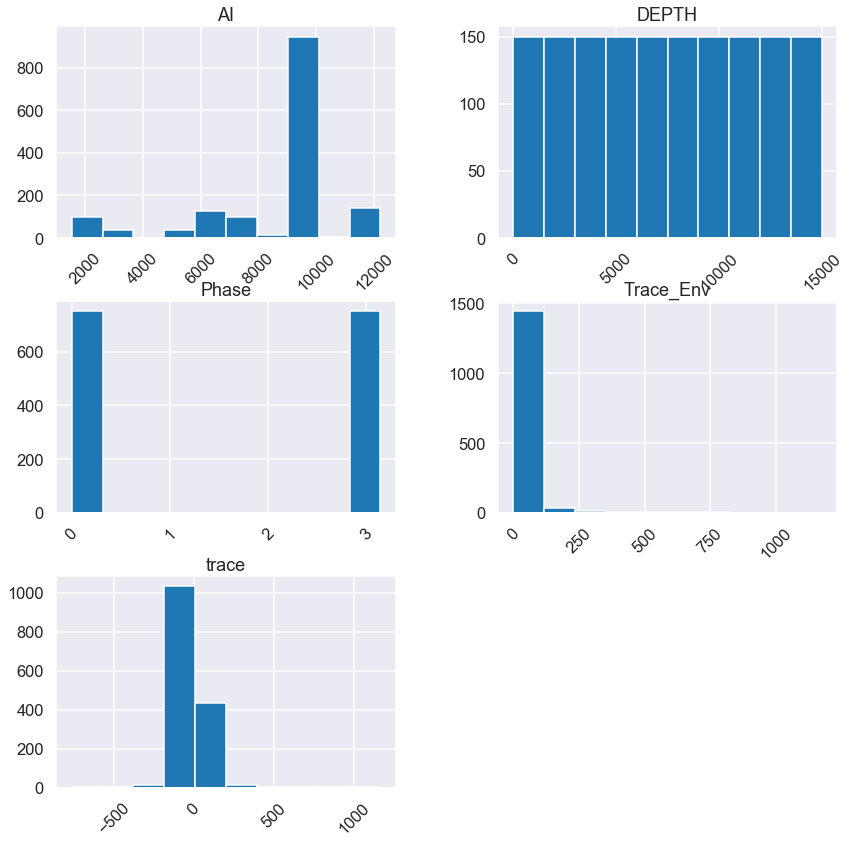

In [45]:
merged_log.hist(figsize=(14, 14), xrot=45)
plt.show()

# 3. Hyperparameterizations and Model validation

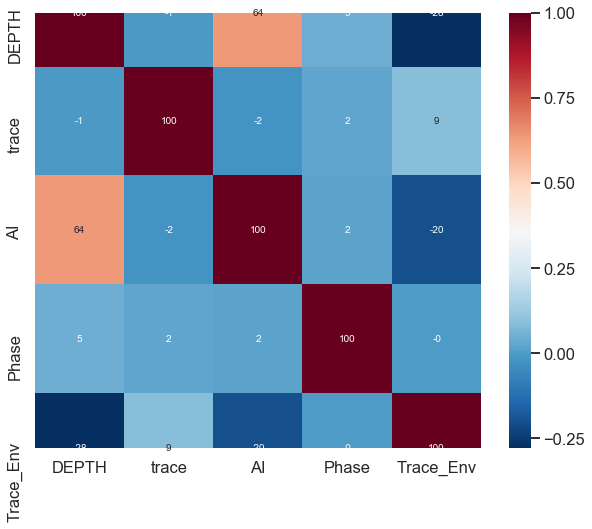

In [46]:
correlations = merged_log.corr()

# Change color scheme
sns.set_style('white')

# Make the figsize 10 x 8
plt.figure(figsize=(10, 8))

# Plot heatmap of correlations

sns.heatmap(correlations, cmap='RdBu_r', annot=correlations*100, fmt='.0f')

In [47]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [48]:
from sklearn.model_selection import train_test_split

## G. Semi-automated Model validations

In [49]:
X = merged_log.drop(['DEPTH', 'well_name', 'AI'], axis=1)
y = merged_log.AI

In [50]:
X.dropna(inplace=True)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

In [52]:
print( len(X_train), len(X_test), len(y_train), len(y_test) )

1200 300 1200 300


In [53]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [54]:
pipelines = {
    'lasso': make_pipeline(StandardScaler(), Lasso()),
    'ridge': make_pipeline(StandardScaler(), Ridge()),
    'enet': make_pipeline(StandardScaler(), ElasticNet()),
    'rf': make_pipeline(StandardScaler(), RandomForestRegressor()),
    'gb': make_pipeline(StandardScaler(), GradientBoostingRegressor())
}

In [55]:
lasso_hyperparameters = { 
    'lasso__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10] 
}
ridge_hyperparameters = { 
    'ridge__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]  
}
enet_hyperparameters = { 
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],                        
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]  
}
rf_hyperparameters = { 
    'randomforestregressor__n_estimators' : [100, 200],
    'randomforestregressor__max_features': ['auto', 'sqrt', 0.33],
}
gb_hyperparameters = { 
    'gradientboostingregressor__n_estimators': [100, 200],
    'gradientboostingregressor__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [1, 3, 5]
}

In [56]:
hyperparameters = {
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters,
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters,
    'enet' : enet_hyperparameters
}

In [57]:
from sklearn.model_selection import GridSearchCV

In [58]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.


In [59]:
from sklearn.exceptions import NotFittedError

for name, model in fitted_models.items():
    try:
        pred = model.predict(X_test)
        print(name, 'has been fitted.')
    except NotFittedError as e:
        print(repr(e))

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.


In [60]:
for name, model in fitted_models.items():
    print( name, model.best_score_ )

lasso 0.029158072171707617
ridge 0.027941888332983056
enet 0.028953093979268
rf 0.4994616294842533
gb 0.5581048619675958


In [61]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [62]:
for name, model in fitted_models.items():
    pred = model.predict(X_test)
    print( name )
    print( '--------' )
    print( 'R^2:', round(r2_score(y_test, pred ), 2))
    print( 'MAE:', round(mean_absolute_error(y_test, pred), 2))
    print()

lasso
--------
R^2: 0.02
MAE: 1833.2

ridge
--------
R^2: 0.02
MAE: 1832.6

enet
--------
R^2: 0.02
MAE: 1840.81

rf
--------
R^2: 0.53
MAE: 1126.69

gb
--------
R^2: 0.6
MAE: 958.85



In [63]:
plot_data = pd.DataFrame({'Test':y_test, 'Prediction':pred})
# plot_data.drop([155], inplace=True)

/Users/brandonallenlee/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


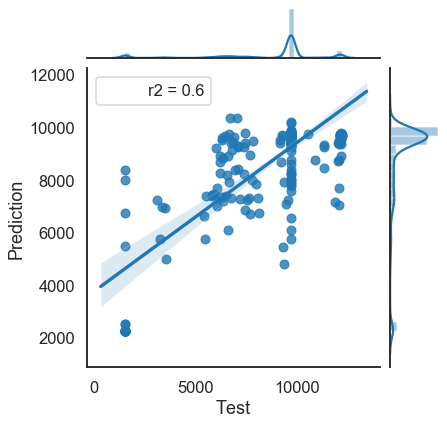

In [64]:
# sns.lmplot('Test', 'Prediction', data=plot_data, )
# #plot_data

from scipy import stats
def r2(x, y):
    return stats.pearsonr(plot_data.Test, plot_data.Prediction)[0] ** 2
sns.jointplot(plot_data.Test, plot_data.Prediction, kind="reg", stat_func=r2)

In [65]:
r2(plot_data.Test, plot_data.Prediction)

0.6043827769259286

#### Preparation of Seismic Section to invert

In [66]:
inline_number = well_seismic_loc.iloc[0]['iline']
inline_number

4007

In [67]:
with segyio.open(segy) as f:
    trace_section = pd.DataFrame(f.iline[inline_number]).T

In [68]:
trace_section.shape

(751, 1169)

## Multi-attributes seismic

In [69]:
# calculate attributes and merge them into multi-array list, mas
mas = []
for i,l in trace_section.iteritems():
    env = pd.Series(envelope(l))
    phase = pd.Series(ins_phase(l))
    temp = [l, env, phase]
    mas.append(temp)


In [70]:
# insert the attributes into the seismic dataframe
multiatt_seismic = pd.DataFrame(mas)
multiatt_seismic.columns = ['trace', 'env', 'phase']
multiatt_seismic = multiatt_seismic.T

In [71]:
multiatt_seismic.T

trace  \
0     0       0.000000
1       0.000000
2       0.00...   
1     0       0.000000
1       0.000000
2       0.00...   
2     0       0.000000
1       0.000000
2       0.00...   
3     0       0.000000
1       0.000000
2       0.00...   
4     0       0.000000
1       0.000000
2       0.00...   
...                                                 ...   
1164  0      0.000000
1      0.000000
2      0.00000...   
1165  0       0.000000
1       0.000000
2       0.00...   
1166  0       0.000000
1       0.000000
2       0.00...   
1167  0      0.000000
1      0.000000
2      0.00000...   
1168  0       0.000000
1       0.000000
2       0.00...   

                                                    env  \
0     0       8.244648
1       4.395298
2       1.79...   
1     0       2.985802
1       0.509256
2       0.79...   
2     0       6.125039
1       4.611974
2       3.19...   
3     0      11.981777
1       8.028074
2       5.99...   
4     0       2.676607
1       0.980935
2       0.84...   
...                                                 ...   
1164  0      0.443231
1      0.985417
2      0.25655...   
1165  0       8.518178
1       4.207814
2       3.05...   
1166  0       9.220175
1       3.103478
2       3.13...   
1167  0       8.857632
1       5.024148
2       4.75...   
1168  0       3.452560
1       1.244987
2       0.70...   

                                                  phase  
0     0      3.141593
1      3.141593
2      3.14159...  
1     0      0.000000
1      3.141593
2      3.14159...  
2     0      0.000000
1      0.000000
2      0.00000...  
3     0      0.000000
1      0.000000
2      0.00000...  
4     0      3.141593
1      0.000000
2      3.14159...  
...                                                 ...  
1164  0      0.000000
1      0.000000
2      0.00000...  
1165  0      0.000000
1      0.000000
2      0.00000...  
1166  0      0.000000
1      0.000000
2      0.00000...  
1167  0      3.141593
1      3.141593
2      3.14159...  
1168  0      0.000000
1      0.000000
2      0.00000...  

[1169 rows x 3 columns]

# 4. AI Prediction

## H. AI prediction on selected seismic inline

#### First pass prediction

In [72]:
pred_ai_all = []
for i,x in multiatt_seismic.iteritems():
    tempdf = pd.DataFrame(x).T
    singledf = pd.DataFrame()
    for j,z in tempdf.iterrows():
        singledf['trace'] = z['trace']
        singledf['env'] = z['env']
        singledf['phase'] = z['phase']

    pred_ai_all.append(model.predict(singledf))
aiforai = pd.DataFrame(pred_ai_all).T
aiforai

0            1            2            3            4     \
0    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157   
1    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157   
2    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157   
3    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157   
4    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157   
..           ...          ...          ...          ...          ...   
746  9480.588746  9452.960940  9689.939780  9445.063767  9434.132058   
747  9876.088941  9202.409489  9480.588746  9153.432796  9445.063767   
748  9649.650126  9625.742726  9876.088941  9625.742726  9876.088941   
749  9649.650126  9848.461134  9848.461134  9876.088941  9649.650126   
750  9649.650126  9848.461134  9848.461134  9848.461134  9649.650126   

            5            6            7            8            9     ...  \
0    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157  ...   
1    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157  ...   
2    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157  ...   
3    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157  ...   
4    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157  ...   
..           ...          ...          ...          ...          ...  ...   
746  9202.409489  9480.588746  9202.409489  9445.063767  9649.650126  ...   
747  9153.432796  9153.432796  9153.432796  9153.432796  9507.054894  ...   
748  9576.766033  9824.163242  9824.163242  9885.064167  9202.409489  ...   
749  9902.555088  9649.650126  9649.650126  9649.650126  9885.064167  ...   
750  9876.088941  9649.650126  9649.650126  9649.650126  9885.064167  ...   

            1159         1160         1161         1162         1163  \
0    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157   
1    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157   
2    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157   
3    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157   
4    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157   
..           ...          ...          ...          ...          ...   
746  9649.650126  9452.960940  9649.650126  9649.650126  9600.454142   
747  9649.650126  9466.332410  9649.650126  9452.960940  9649.650126   
748  9649.650126  9876.088941  9452.960940  9848.461134  9452.960940   
749  9649.650126  9848.461134  9848.461134  9649.650126  9480.588746   
750  9649.650126  9649.650126  9848.461134  9649.650126  9876.088941   

            1164         1165         1166         1167         1168  
0    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157  
1    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157  
2    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157  
3    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157  
4    2251.506157  2251.506157  2251.506157  2251.506157  2251.506157  
..           ...          ...          ...          ...          ...  
746  9649.650126  9649.650126  9452.960940  9649.650126  9600.454142  
747  9452.960940  9480.588746  9480.588746  9649.650126  9649.650126  
748  9848.461134  9153.432796  9202.409489  9649.650126  9480.588746  
749  9848.461134  9625.742726  9902.555088  9649.650126  9480.588746  
750  9649.650126  9848.461134  9861.832605  9649.650126  9848.461134  

[751 rows x 1169 columns]

Text(0.5, 1.0, 'Split Training Prediction Test')

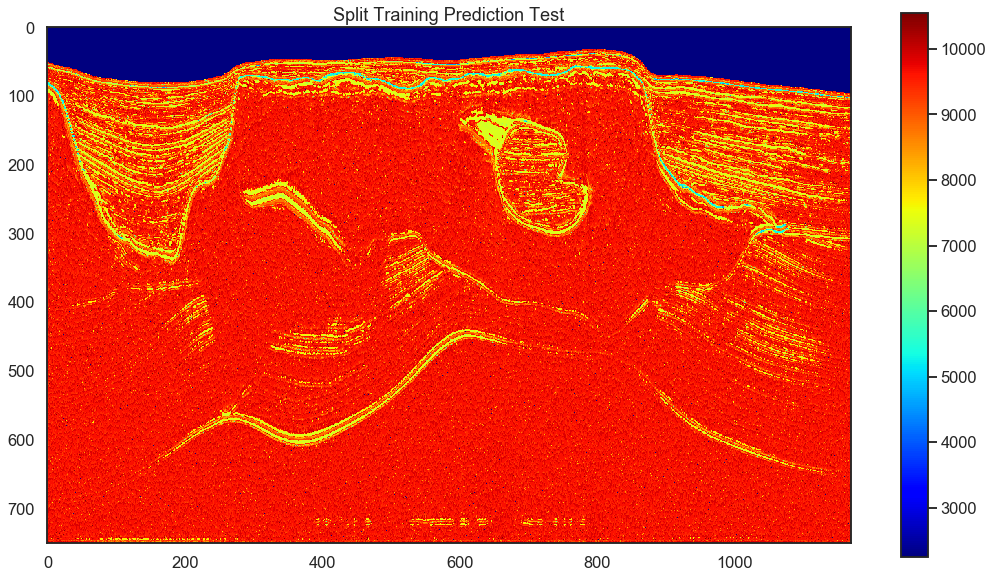

In [73]:
plt.figure(figsize=(18,10))
plt.imshow(aiforai, cmap='jet')
plt.colorbar()
plt.title('Split Training Prediction Test')

#### Re-training using whole dataset

In [74]:
final_model = GridSearchCV(pipelines.get('gb'), hyperparameters.get('gb'), cv=10)
final_model.fit(X, y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(alpha=0.9,
                                                                  criterion='friedman_mse',
                                                                  init=None,
                                                                  learning_rate=0.1,
                                                                  loss='ls',
                                                                  max_depth=3,
                                                                  max_features=

#### Final AI prediction

Text(0.5, 1.0, 'Final_model_prediction')

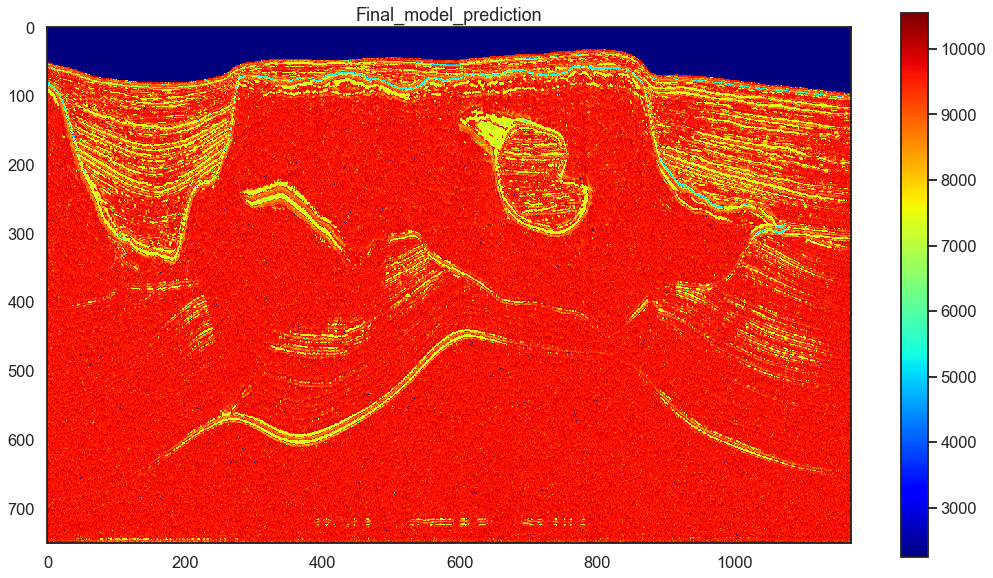

In [75]:

pred_ai_all = []
for i,x in multiatt_seismic.iteritems():
    tempdf = pd.DataFrame(x).T
    singledf = pd.DataFrame()
    for j,z in tempdf.iterrows():
        singledf['trace'] = z['trace']
        singledf['env'] = z['env']
        singledf['phase'] = z['phase']
    pred_ai_all.append(model.predict(singledf))
aiforai = pd.DataFrame(pred_ai_all).T
pred_ai_df_final= pd.DataFrame(pred_ai_all)
plt.figure(figsize=(18,10))
plt.imshow(aiforai, cmap='jet')
plt.colorbar()
plt.title('Final_model_prediction')